# Preparacion de los datos

## Generar data frame

*Primeramente, cargamos los conjuntos de datos utilizando la función pandas `read_csv()`. Dado que los datos contienen caracteres especiales en español, así que tuvimos que especificar la codificación correcta `encoding='latin1'` para garantizar que estos caracteres se lean correctamente.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Cargamos los datos
INEGI = pd.read_csv('datosINEGI.csv')
CONEVAL = pd.read_csv('datosConeval.csv', encoding='latin1')

<ipython-input-2-db8addb18b91>:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  INEGI = pd.read_csv('/content/gdrive/MyDrive/DATASETS/conjunto_de_datos_iter_00CSV20.csv')


*El dataset incluye varios niveles de granularidad de los datos, entonces para centrarnos en los datos aggregados a nivel municipal, filtramos las filas en las que la columna `NOM_LOC` (Nombre Local) es igual a "Total del Municipio".Así que nos asegura que nuestro análisis se base en datos municipales completos y no en localidades más granulares.*

In [ ]:
# # # Filter rows where NOM_LOC == "Total del Municipio"
INEGI_total = INEGI[INEGI['NOM_LOC'] == "Total del Municipio"]

*En los datasets en los que varias regiones comparten los mismos códigos de municipio, nos es esencial crear un identificador único para cada municipio para evitar ambigüedades. Lo cual conseguimos combinando las columna `ENTIDAD` (Código de Estado) y `MUN` (Código de Municipio) columnas. Para esto, multiplicamos `ENTIDAD` por 1000 y luego añadimos `MUN` y nos funciona ya que cada municipio, incluso los que tienen el mismo `MUN` en distintos estados, tengan un identificador distinto.*

In [ ]:
# # # Make MUN in INEGI_total be ENTIDAD * 1000 + MUN
INEGI_total['MUN'] = INEGI_total['ENTIDAD'] * 1000 + INEGI_total['MUN']

<ipython-input-4-72cafc7c04ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  INEGI_total['MUN'] = INEGI_total['ENTIDAD'] * 1000 + INEGI_total['MUN']


*Para nuestro análisis, nos centramos en columnas específicas dentro del dataset del CONEVAL, puesto que*

*`clave_municipio` Es análogo al código de municipio del dataset del INEGI.*

*`pobreza_m` Porcentaje de la población en situación de pobreza moderada*

*`ic_asalud` Porcentaje de la población con carencia por acceso a los servicios de salud*

In [ ]:
# # # Drop columns that are not needed from CONEVAL(only columns needed are 'clave_municipio', 'pobreza_m', "ic_asalud")
CONEVAL = CONEVAL[['clave_municipio', 'pobreza_m', 'ic_asalud']]

*Realizamos una operación de fusión de datasets con información tanto del INEGI como del CONEVAL, la cual nos permite combinar datos relacionados basándonos en una clave común. En este caso, fusionamos la columna `MUN` del dataset del INEGI y la columna `clave_municipio` del dataset del CONEVAL. Así como es importante notar que estas columnas, aunque representan la misma entidad, tienen nombres diferentes. Para esot la funcion `pd.merge()` de pandas nos facilita esta tarea al permitirnos especificar las columnas a unir mediante parámetros `left_on` y `right_on`. Por ende tras la fusión, la columna `clave_municipio` resulta redundante, ya que su información está ahora integrada en el dataset, por lo que la eliminamos para mantener un datast limpio.*

In [ ]:
# # # MERGE INEGI_total and CONEVAL from MUN and clave_municipio
merged = pd.merge(INEGI_total, CONEVAL, left_on='MUN', right_on='clave_municipio')

# # # Drop clave_municipio
merged = merged.drop(columns=['clave_municipio'])

*Eliminamos las columnas que no son esenciales para nuestro análisis, en concreto, eliminamos las nueve primeras columnas, que pueden contener metadatos u otra información extraña, así que este paso reduce el desorden de los datos y centra nuestro dataset en las variables de interés.*

In [ ]:
# # #Drop columns that are not needed from merged, first 9 columns are not needed
merged = merged.drop(columns=merged.columns[0:9])

# # # drop TAMLOC column
merged = merged.drop(columns='TAMLOC')

*Aseguramos de que todos los datos están en formato numérico para poder realizar cálculos y análisis sin problemas. De modo que utilizamos la función `pd.to_numeric()` para convertir los datos aplicables a tipos numéricos, al mismo tiempo que puede coaccionar valores no numéricos a `NaN` (Not a Number).*

In [ ]:
# # #fix data types, all numeric
merged = merged.apply(pd.to_numeric, errors='coerce')

*Tras el procesamiento, guardamos el dataset depurado como `merged.csv`, para que los datos procesados se almacenen para su uso futuro, preservando los resultados de nuestros esfuerzos de preparación de datos. Además, al mostrar la forma del dataset (es decir, el número de filas y columnas), obtenemos una rápida visión general de sus dimensiones, lo que puede ser útil para comprender el alcance de nuestros datos.*

In [ ]:
# # # Save the merged data
merged.to_csv('merged.csv', index=False)

merged.shape, CONEVAL.shape, INEGI_total.shape

((2469, 278), (2469, 3), (2469, 286))

## Preparación y escalamiento de la base de datos.
### Se eliminan filas donde existan valores nulos, y se revisa que no queden de estos.
### Se hace un escalamiento de los datos en un rango de 0 a 1, para su uso en modelos para feturing selection.
### Se separan los datos para entrenar los modelos de selección de variables.


*Después de fusionar los datasets, nos interesa preparar los datos para el análisis tratando los valores que faltan, escalando las características y definiendo las variables de entrada y de destino.*

*Los datos que faltan pueden dar lugar a análisis sesgados y reducir la potencia estadística de los modelos. Por lo tanto, ocupamos elimanar a las filas con valores perdidos.*

In [ ]:
data = pd.read_csv('merged.csv')
data['pobreza_m'] = data['pobreza_m'].fillna(data['pobreza_m'].mean())
print(data.shape)
print(data.isna().sum())

# divide columns that start with P by POBTOT and columns tht start with V by VIVTOT
p_cols = [col for col in data.columns if col.startswith('P')]
v_cols = [col for col in data.columns if col.startswith('V')]
data[p_cols] = data[p_cols].div(data['POBTOT'], axis=0)
data[v_cols] = data[v_cols].div(data['VIVTOT'], axis=0)




data.head()

(2469, 278)
POBTOT         0
POBFEM         0
POBMAS         0
P_0A2          0
P_0A2_F        0
              ..
VPH_SINLTC     0
VPH_SINCINT    0
VPH_SINTIC     0
pobreza_m      0
ic_asalud      3
Length: 278, dtype: int64


,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,pobreza_m,ic_asalud
0,1.0,0.513090,0.486910,0.046757,0.023070,0.023687,0.952259,0.489527,0.462732,0.918021,...,0.570201,0.415922,0.258418,0.179186,0.010531,0.023281,0.236953,0.002334,21.7,20.0
1,1.0,0.509838,0.490162,0.061510,0.031803,0.029707,0.938102,0.477841,0.460261,0.894423,...,0.294796,0.252850,0.038820,0.036214,0.024555,0.094249,0.469355,0.011529,36.0,16.5
2,1.0,0.509648,0.490352,0.054232,0.027142,0.027090,0.945167,0.482197,0.462970,0.904567,...,0.314413,0.227857,0.066308,0.064869,0.021255,0.043374,0.386767,0.006621,41.3,21.0
3,1.0,0.512235,0.487765,0.060706,0.031706,0.029000,0.939294,0.480529,0.458765,0.897294,...,0.359340,0.343447,0.046027,0.039422,0.028689,0.085449,0.394634,0.010320,33.7,17.6
4,1.0,0.505738,0.494262,0.053452,0.026014,0.027438,0.945478,0.479185,0.466293,0.904887,...,0.479422,0.324501,0.223730,0.158412,0.011552,0.027677,0.275499,0.003562,23.1,21.1


*Como en el aprendizaje supervisado, se distringue entre características de entrada (X) y variables objetivo (Y).*

*`X` Son los predictores utilizados por el modelo para hacer predicciones, en nuestro caso, se seleccionan como características todas las columnas excepto las dos últimas.*

*`Y` Son los resultados que el modelo pretende predecir.*
*   *Y_pobreza Representa el indicador de pobreza moderada.*
*   *Y_salud Representa el indicador de acceso a la sanidad*


In [ ]:
array = data.values

X = array[:, :-2]
Y_pobreza = array[:, -2]
Y_salud = array[:, -1]

# FEATURE SELECTION DE POBREZA MODERADA

*Random Forest es un método de aprendizaje por conjuntos que construyee múltiples árboles de decisión durante el entrenamiento y genera la predicción media de los árboles individuales. Lo cual resulta especialmente útil para evaluar la importancia de las características debido a su capacidad inherente para evaluar la contribución de cada característica a la hora de realizar predicciones.*

In [ ]:
# RandomForest pobreza
names = np.array(data.columns[:-2])

Empleamos `RandomForestRegressor` para predecir la variable objetivo `pobreza_m`. Justo este modelo aprende patrones en los datos considerando varios subconjuntos de características y observaciones, asegurando así la robustez frente al sobreajuste.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

*Para identificar y retener sólo las caracterísitcas más significativas, utilizamos `SelectFromModel`. Por defecto, retiene las características cuya importancia es mayor que la importancia media de todas las características.*

In [ ]:
from sklearn.feature_selection import SelectFromModel

*Tras ajustar el modelo, se asigna a cada característica una puntuación de importancia, que refleja su contribución a la predicción. Por lo que, la clasificación de estas características en orden descendente de importancia proporciona información sobre qué características son las más influyentes*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_SINLTC' 'PDER_IMSS' 'VPH_PISOTI' 'PDER_SEGP'
 'PDER_ISTE' 'VPH_AGUAFV' 'P_15YMAS_M' 'P_12YMAS_M' 'VPH_REFRI'
 'P_18YMAS_M' 'PSINDER' 'VPH_NODREN' 'P15YM_AN_F' 'VPH_NDACMM'
 'P15PRI_COF' 'P15PRI_CO' 'PAFIL_IPRIV' 'VPH_TINACO' 'PDER_SS' 'VPH_STVP'
 'VPH_RADIO' 'VPH_AUTOM' 'P15SEC_COF' 'VPH_1CUART' 'P3HLINHE_M'
 'VPH_2CUART' 'VPH_SNBIEN' 'P8A14AN' 'P15YM_SE_F' 'P15SEC_CO' 'VPH_NDEAED'
 'VPH_S_ELEC' 'VPH_LETR']


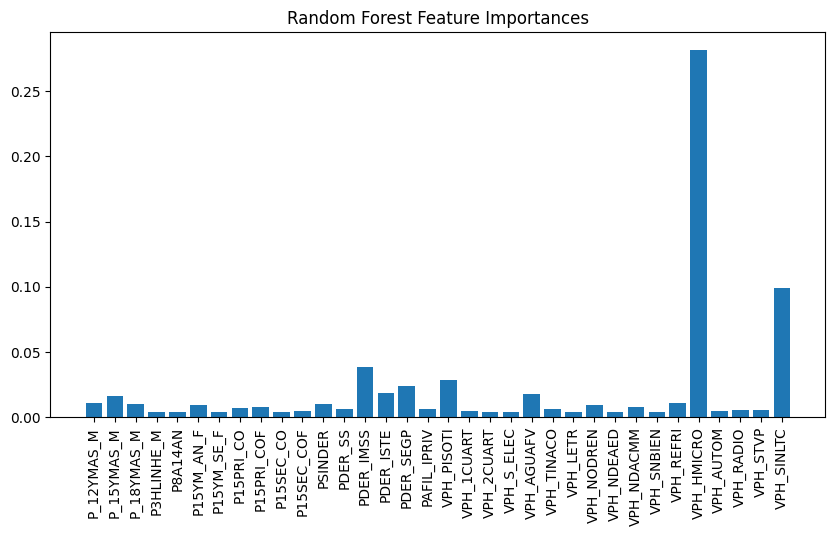

In [ ]:
rf = RandomForestRegressor(n_estimators=150, random_state=42).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=rf, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = rf.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)

# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*El `ExtraTreesRegressor` es otro método de conjunto que agrega los resultados de múltiples árboles de decisión descorrelacionados para producir una predicción. A diferencia de los bosques aleatorios, que utilizan el muestreo bootstrap y buscan la división óptima en cada nodo, los árboles adicionales seleccionan los puntos de corte aleatoriamente y utilizan todo el conjunto de datos para el entrenamiento. Por lo cual esta aleatoriedad puede reducir la varianza y la eficiencia computacional que nos beneficia.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'PDER_IMSS' 'VPH_AUTOM' 'PDER_SEGP' 'VPH_SINLTC'
 'VPH_NDACMM' 'P15YM_AN_F' 'VPH_PISOTI' 'VPH_CVJ' 'PDER_ISTE' 'VPH_SNBIEN'
 'VPH_TINACO' 'P_18YMAS_M' 'PSINDER' 'P_15YMAS_M' 'PDER_SS' 'VPH_NODREN'
 'VPH_SINCINT' 'VPH_REFRI' 'P15PRI_CO' 'VPH_STVP' 'P3HLINHE_M'
 'VPH_SPMVPI' 'VPH_PC' 'P_12YMAS_M' 'VPH_1CUART' 'P15PRI_COF' 'P15PRI_COM'
 'P8A14AN' 'VPH_2CUART' 'VPH_C_SERV' 'P8A14AN_M' 'P18YM_PB_M' 'VPH_LAVAD'
 'P15YM_AN' 'P15YM_SE_F' 'GRAPROES' 'VPH_RADIO' 'VPH_SINRTV' 'P3HLINHE'
 'VPH_BICI']


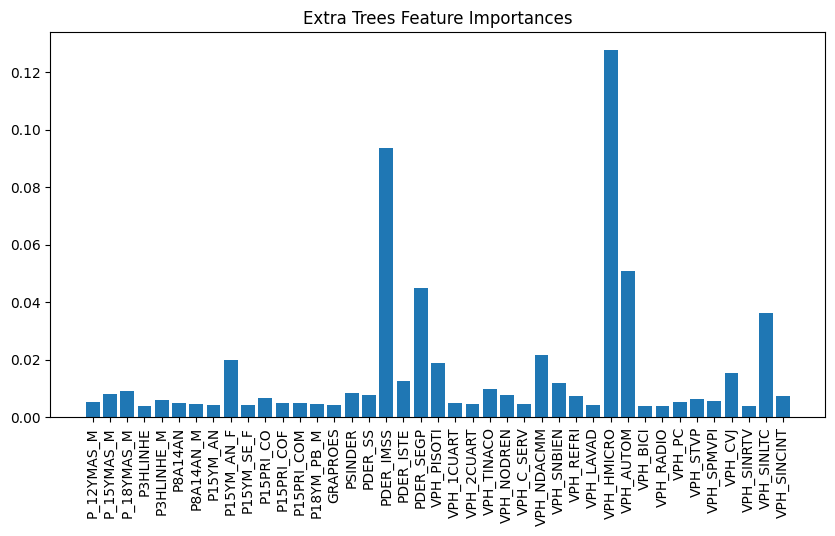

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=150, random_state=42).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=et, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = et.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("Extra Trees Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*XGBoost (Extreme Gradient Boosting) es una implementación potente y eficiente de los algoritmos de refuerzo de gradiente. Asi mismo, está diseñado para ofrecer velocidad y rendimiento, lo que a menudo se traduce en una precisión predictiva superior.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_SINLTC' 'P15PRI_COF' 'VPH_PISOTI' 'PDER_SEGP'
 'PDER_ISTE' 'P_18YMAS_M' 'P_60A64' 'PDER_IMSS' 'VPH_AGUAFV' 'P3HLINHE_M'
 'VPH_NODREN' 'VPH_C_SERV' 'VPH_S_ELEC' 'PSINDER' 'P_15YMAS_M'
 'P_12YMAS_M' 'POCUPADA_M' 'VPH_RADIO' 'VPH_AUTOM' 'VPH_1CUART'
 'P15SEC_COF' 'VPH_REFRI' 'P15SEC_CO' 'POCUPADA' 'PSIND_LIM' 'P_8A14_F'
 'P_5A9' 'GRAPROES' 'VPH_3YMASC' 'VPH_SINRTV' 'VPH_NDACMM' 'P_0A4_M'
 'P15YM_AN_M' 'P_70A74_M' 'PDER_SS' 'PAFIL_IPRIV' 'VPH_SINTIC'
 'P15YM_AN_F' 'VPH_SNBIEN' 'VPH_TV' 'P8A14AN_F' 'VPH_STVP' 'P15YM_SE_M'
 'PRES2015_F' 'PHOGJEF_M' 'VPH_DRENAJ' 'P_3YMAS_M' 'PEA_F' 'VIVPARH_CV'
 'P18YM_PB_F']


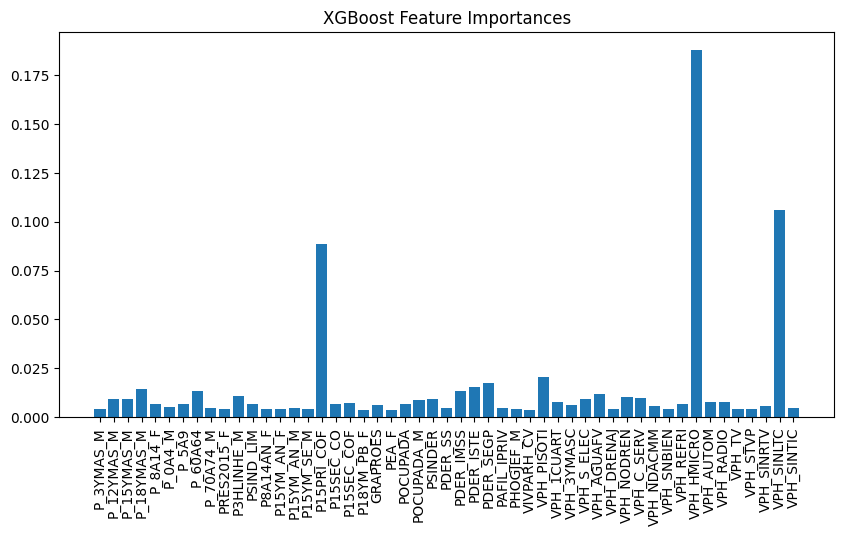

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=50).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=xgb, threshold='mean')
selector.fit(X, Y_pobreza)

selected = selector.get_support()
s_features = names[selected]
selected_importances = xgb.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("XGBoost Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Aquí tenemos otro enfoque, ya que calculamos la correlación estadística entre cada característica y la variable objetivo `pobreza_m`. Las características con los coeficientes de correlación más altos (ya sean positivos o negativos) se consideran más relevantes. También, la selección de las 10 características principales basada en estas correlaciones ayuda a centrarse en las variables con mayor impacto, mejorando potencialmente el rendimiento y la interpretabilidad del modelo.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'PDER_IMSS' 'VPH_CVJ' 'VPH_AUTOM' 'PDER_SEGP' 'VPH_SPMVPI'
 'VPH_PC' 'VPH_INTER' 'P18YM_PB_M' 'P18YM_PB']


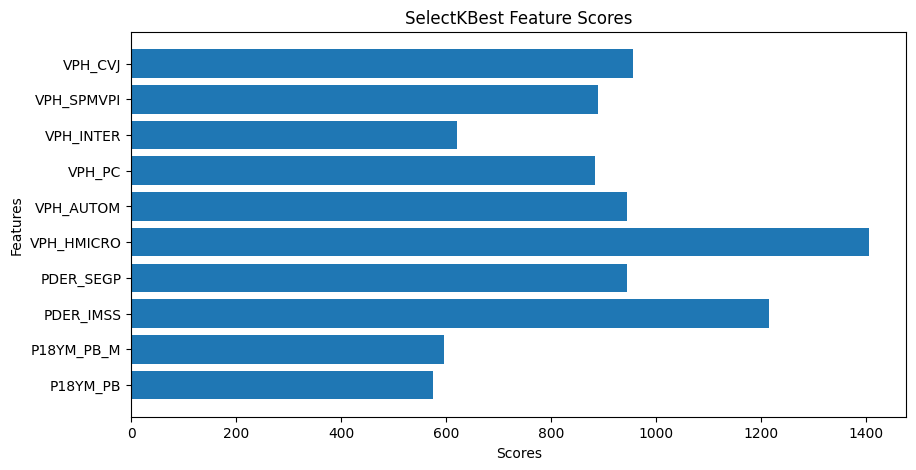

In [ ]:
# SelectKbest pobreza

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(score_func=f_regression, k=10).fit(X, Y_pobreza)
selected = skb.get_support()
selected_features = names[selected]
selected_scores = skb.scores_[selected]
sorted_features = selected_features[np.argsort(selected_scores)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_features)
plt.figure(figsize=(10, 5))
plt.barh(selected_features, selected_scores)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('SelectKBest Feature Scores')
plt.show()

## FEATURE SELECTION DE IC_SALUD

*Se entrena un `RandomForestRegressor` utilizando `ic_asalud` como variable objetivo, así como el `SelectFromModel` se utiliza para retener sólo las características más importantes, filtrando aquellas con puntuaciones de importancia por debajo de la media. Ayudandonos a comprender qué factores socioeconómicos contribuyen más al acceso a la sanidad y funciona bien con conjuntos de datos que contienen datos numéricos y categóricos.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'OCUPVIVPAR']


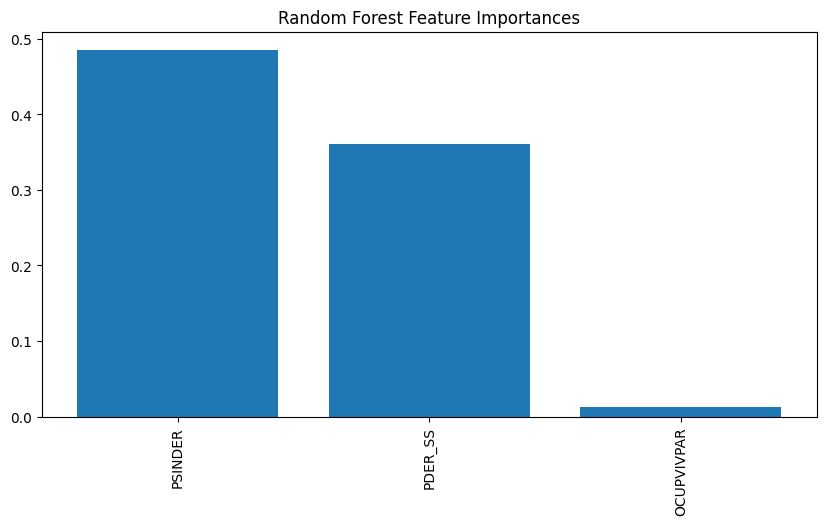

In [ ]:
# RandomForest ICSS

rf = RandomForestRegressor(n_estimators=150, random_state=42).fit(X, Y_salud)
selector = SelectFromModel(estimator=rf, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = rf.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*El modelo `ExtraTreesRegressor` se entrena con `ic_asalud` como objetivo.Así mismo, se extraen las puntuaciones de importancia de las característica y se clasifican las características y se eliminan las menos importantes.
Nos es útil porque funciona bien cuando las características del conjunto de datos tienen una alta correlació y ayuda a comprender la importancia de las relaciones no lineales en los datos.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'PDER_SEGP' 'PEA' 'PE_INAC' 'PE_INAC_F' 'POCUPADA_F'
 'PEA_F']


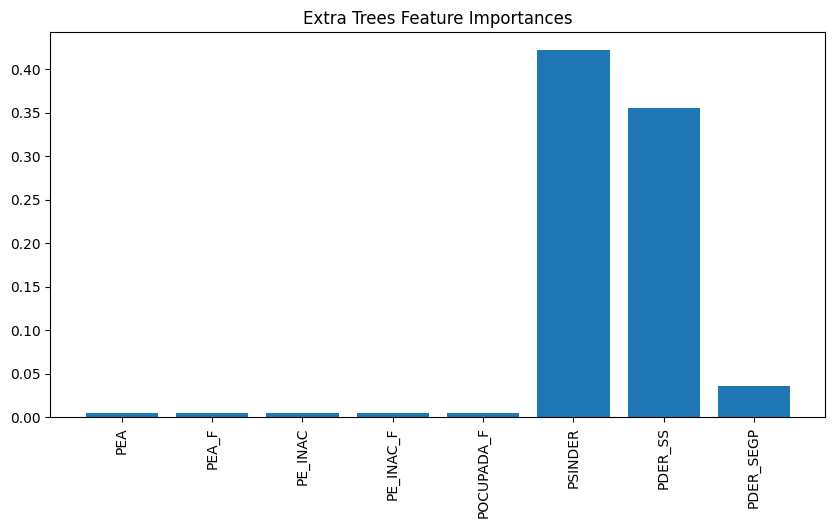

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=150, random_state=42).fit(X, Y_salud)
selector = SelectFromModel(estimator=et, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = et.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("Extra Trees Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Nuevamente XGBoost es un potente algoritmo de aprendizaje automático que construye árboles secuencialmente, corrigiendo los errores de los árboles anteriores.*
*Destacando las las características en función de*
*   *Ganancia (cuánto mejora una característica la precisión del modelo cuando se utiliza como división).*
*   *Cobertura (frecuencia con la que se utiliza una característica para dividir los árboles).*
*   *Peso (el número de veces que se utiliza una característica en las divisiones).*


Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'VPH_3YMASC' 'P15SEC_COM' 'P18A24A' 'OCUPVIVPAR'
 'P15SEC_CO' 'PCDISC_LENG' 'PSIND_LIM' 'P_60A64_F' 'P_60A64_M' 'P15SEC_IN'
 'PAFIL_PDOM' 'P15A17A_F' 'P_8A14_F' 'VPH_LETR' 'P3A5_NOA_M' 'P12YM_SEPA'
 'P15PRI_COF' 'P15PRI_CO' 'PCON_LIMI' 'PCDISC_MEN' 'TVIVPAR' 'POB_AFRO'
 'VPH_LAVAD' 'VPH_PISOTI' 'PEA_M' 'P_50A54_M' 'P_15YMAS_F' 'VPH_2CUART'
 'PCLIM_HACO' 'VPH_1CUART' 'POCUPADA_M' 'P15A17A_M' 'P3HLINHE' 'TOTHOG'
 'P_10A14_F' 'P_0A4' 'PNACENT_F' 'P3A5_NOA' 'P_85YMAS_M' 'PEA' 'PE_INAC_F'
 'VIVPAR_DES' 'PDER_ISTE' 'PCDISC_VIS' 'POB_AFRO_M' 'VPH_AGUAFV' 'PE_INAC'
 'PRES2015_F' 'VPH_MOTO' 'PAFIL_OTRAI' 'PCLIM_RE_CO' 'VPH_SINRTV'
 'P_40A44' 'PNACOE' 'P_70A74_F' 'P8A14AN_F' 'P15YM_SE_F' 'PDER_ISTEE'
 'PRO_OCUP_C' 'P_15A19' 'P5_HLI_NHE' 'PCON_DISC']


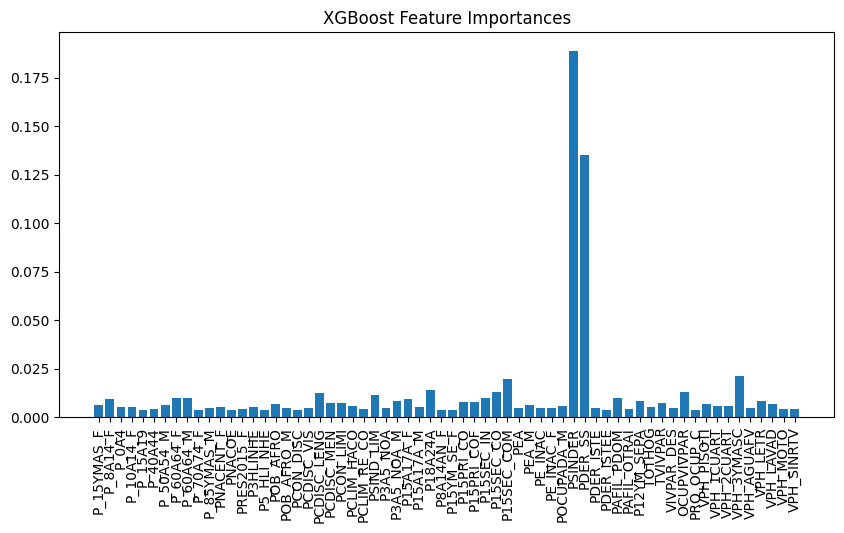

In [ ]:
xgb = XGBRegressor(n_estimators=10).fit(X, Y_salud)
selector = SelectFromModel(estimator=xgb, threshold='mean')
selector.fit(X, Y_salud)

selected = selector.get_support()
s_features = names[selected]
selected_importances = xgb.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.title("XGBoost Feature Importances")
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Se busca que seleccionen las 10 características con mayor correlación estadística con `ic_asalud`. Con el  objetivo es capturar los predictores más relevantes para el acceso a la sanidad.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'PDER_SEGP' 'POCUPADA_F' 'PEA_F' 'PE_INAC' 'POCUPADA'
 'PEA' 'PE_INAC_F' 'PE_INAC_M']


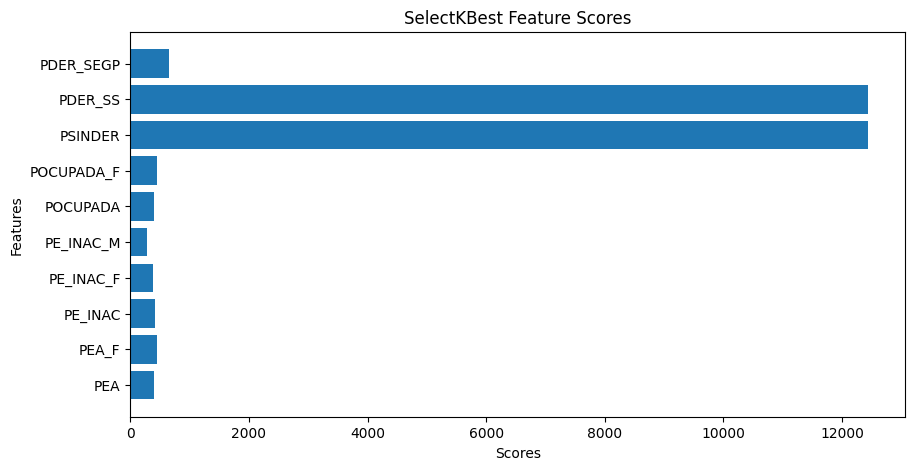

In [ ]:
# SelectKbest ICSS

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(score_func=f_regression, k=10).fit(X, Y_salud)
selected = skb.get_support()
selected_features = names[selected]
selected_scores = skb.scores_[selected]
sorted_features = selected_features[np.argsort(selected_scores)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_features)
plt.figure(figsize=(10, 5))
plt.barh(selected_features, selected_scores)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('SelectKBest Feature Scores')
plt.show()

# Bases de datos con características escogidas

*Creamos un nuevo dataset `dataI1.csv` con las con las características más importantes para `pobreza_m` y al mismo tiempo se descarga el archivo en el ordenador local*

In [ ]:
# dataI1 = data[['PRO_OCUP_C', 'PDER_IMSS', 'PROM_OCUP', 'VPH_AUTOM', 'GRAPROES', 'PDER_SS', 'PSINDER', 'P15SEC_CO','VPH_NODREN', 'VPH_PC', 'pobreza_m']]
# dataI1.to_csv('dataI1.csv', index=False)

*Hace lo mismo para ic_asalud, almacenándolo en `dataI2.csv`.*

In [ ]:
# # Variables seleccionadas por indicador pobreza moderada
# dataI1 = data[['VPH_HMICRO', 'VPH_PC','PDER_IMSS','VPH_CEL', 'VPH_AUTOM', 'VPH_REFRI', 'pobreza_m']]
dataI1 = data[['VPH_SINLTC', 'VPH_NDACMM', 'VPH_INTER','VPH_SPMVPI', 'VPH_HMICRO', 'VPH_PC', 'VPH_CEL',  'VPH_REFRI', 'VPH_CVJ', 'VPH_AUTOM', 'P_60A64', 'P15PRI_COF', 'P15YM_AN_F', 'P18YM_PB_M', 'P18YM_PB', 'PDER_IMSS', 'PDER_SEGP', 'pobreza_m']]

# # Guardas las variables seleccionadas en un archivo csv
dataI1.to_csv('dataI1.csv', index=False)

#Variables seleccionadas por indicador 
dataI2 = data[['PSINDER', 'PDER_SEGP', 'P18A24A_M', 'PROM_HNV', 'POCUPADA_F', 'PEA_F', 'P15PRI_CO', 'P15SEC_COM', 'P15SEC_CO','ic_asalud']]
# dataI2 = data
dataI2.to_csv('dataI2.csv', index=False)

# Generación y Modelado de modelos de aprendizaje automático.

## *Resumen*

*Después de cargar las variables para nuestro proceso de modelado se entrenan 10 diferentes modelos de regresión de machine learning con parámetros iniciales muy sencillos, y de los cuales los mejores cinco modelos se repetiría el proceso con parámetros más desarollados, durante todo este proceso se utilizaron diferentes métricas para evaluar el rendimiento de los modelos que sirvieron principalmente para compararlos entre sí. Los modelos fueron ajustados a los datos de entrenamiento y luego se evaluaron con los datos de prueba, finalmente se mostraron los resultados de maneras gráficas para un mejore entendimiento.*

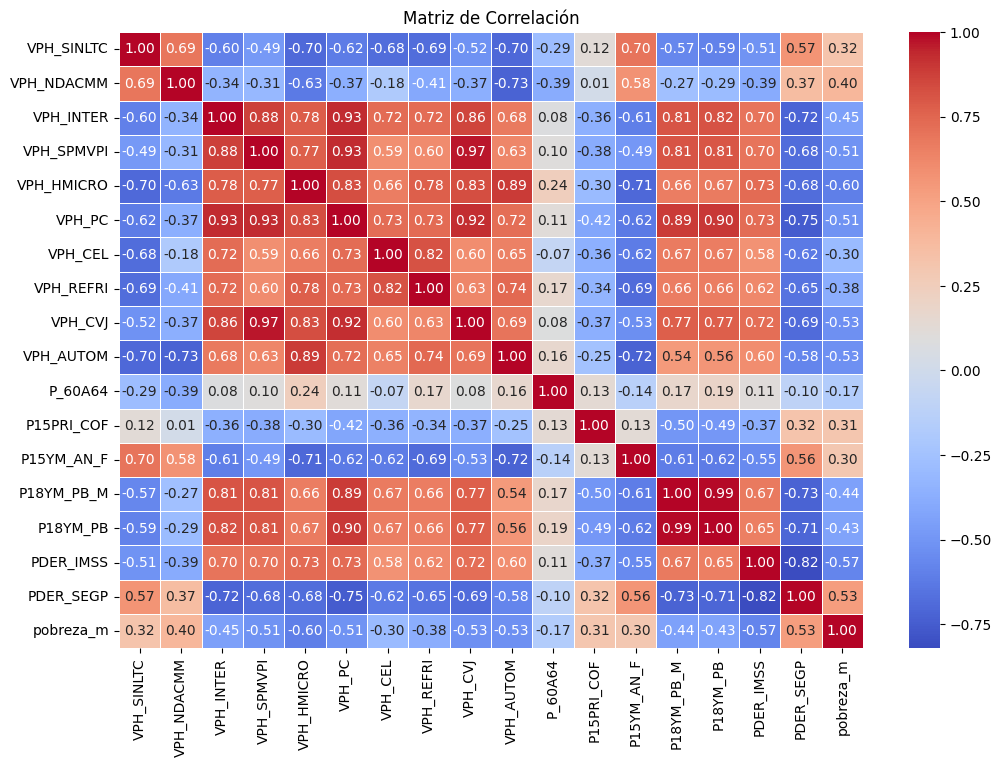

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = dataI1.corr()

# Graficar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# Modelos Pobreza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

dataI1 = pd.read_csv('/content/dataI1 (3).csv')

X = dataI1.drop('pobreza_m', axis=1)
y = dataI1['pobreza_m']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = []
mse_list = []
mae_list = []
r2_list = []

model.append(('LR', LinearRegression()))
model.append(('Ridge', Ridge(alpha=1.0, solver='svd')))
model.append(('LASSO', Lasso(alpha=0.1)))
model.append(('EN', ElasticNet(alpha=1.0, l1_ratio=0.1)))
model.append(('KNN', KNeighborsRegressor(n_neighbors=7)))
model.append(('CART', DecisionTreeRegressor(criterion='squared_error')))
model.append(('SVR', SVR(C = 100.0, epsilon = 1.0, gamma = 'scale', kernel = 'rbf')))
model.append(('RF', RandomForestRegressor(n_estimators=450)))
model.append(('GBM', GradientBoostingRegressor(n_estimators=450)))
model.append(('ETR', ExtraTreesRegressor(n_estimators=450)))
model.append(('XGB', XGBRegressor(n_estimators=450, learning_rate=0.1)))

In [ ]:
for name, m in model:
  m.fit(x_train, y_train)
  y_pred = m.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(name, m)
  print(f"Error Cuadrático Medio (MSE): {mse}")
  print(f"Error Absoluto Medio (MAE): {mae}")
  print(f"Coeficiente de Determinación (R²): {r2}")
  print('---------------------------')
  mse_list.append(mse)
  mae_list.append(mae)
  r2_list.append(r2)

LR LinearRegression()
Error Cuadrático Medio (MSE): 69.69744370153214
Error Absoluto Medio (MAE): 6.396014123548778
Coeficiente de Determinación (R²): 0.4893928004540561
---------------------------
Ridge Ridge(solver='svd')
Error Cuadrático Medio (MSE): 69.6726234941956
Error Absoluto Medio (MAE): 6.391732738692294
Coeficiente de Determinación (R²): 0.48957463462023487
---------------------------
LASSO Lasso(alpha=0.1)
Error Cuadrático Medio (MSE): 76.09322736380267
Error Absoluto Medio (MAE): 6.650663523704622
Coeficiente de Determinación (R²): 0.44253694733728155
---------------------------
EN ElasticNet(l1_ratio=0.1)
Error Cuadrático Medio (MSE): 123.9276457694737
Error Absoluto Medio (MAE): 8.868810096277556
Coeficiente de Determinación (R²): 0.09209944020828298
---------------------------
KNN KNeighborsRegressor(n_neighbors=7)
Error Cuadrático Medio (MSE): 53.69954390572321
Error Absoluto Medio (MAE): 5.636937773030743
Coeficiente de Determinación (R²): 0.6065942698269573
--------

<ipython-input-3-58429f08830e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MSE', y='Modelo', data=results_df, ax=axes[0], palette='coolwarm')
<ipython-input-3-58429f08830e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Modelo', data=results_df, ax=axes[1], palette='coolwarm')
<ipython-input-3-58429f08830e>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Modelo', data=results_df, ax=axes[2], palette='coolwarm')


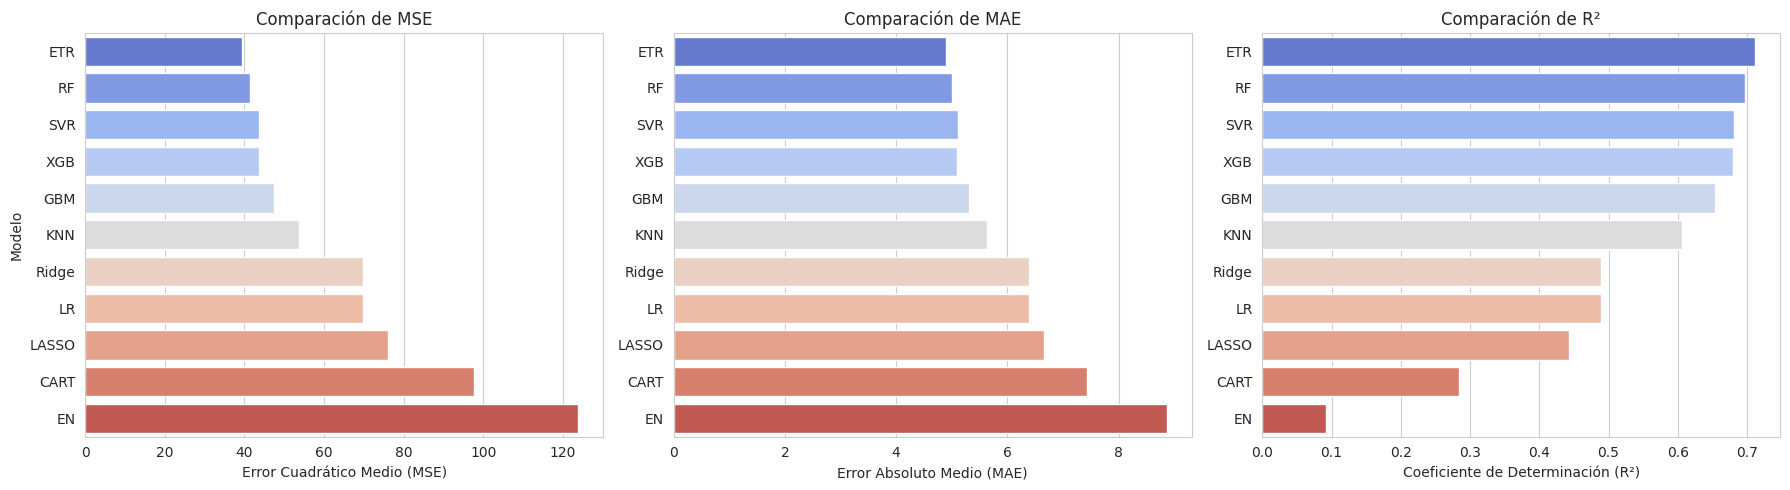

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame({
    'Modelo': [name for name, _ in model],
    'MSE': mse_list,
    'MAE': mae_list,
    'R2': r2_list
})

results_df = results_df.sort_values(by='R2', ascending=False)

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='MSE', y='Modelo', data=results_df, ax=axes[0], palette='coolwarm')
axes[0].set_title("Comparación de MSE")
axes[0].set_xlabel("Error Cuadrático Medio (MSE)")
axes[0].set_ylabel("Modelo")

sns.barplot(x='MAE', y='Modelo', data=results_df, ax=axes[1], palette='coolwarm')
axes[1].set_title("Comparación de MAE")
axes[1].set_xlabel("Error Absoluto Medio (MAE)")
axes[1].set_ylabel("")

sns.barplot(x='R2', y='Modelo', data=results_df, ax=axes[2], palette='coolwarm')
axes[2].set_title("Comparación de R²")
axes[2].set_xlabel("Coeficiente de Determinación (R²)")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import root_mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = []
models.append(('SVR', SVR(C = 100.0, epsilon = 1.0, gamma = 'scale', kernel = 'rbf')))
models.append(('RF', RandomForestRegressor(n_estimators=300, max_depth=100, max_leaf_nodes=80, criterion='squared_error', random_state=4)))
models.append(('ETR', ExtraTreesRegressor(n_estimators=300, max_depth=100, max_leaf_nodes=80, criterion='squared_error', random_state=4)))

new_mse_train = []
new_mae_train = []
new_r2_train = []
new_rmse_train = []

new_mse_test = []
new_mae_test = []
new_r2_test = []
new_rmse_test = []

for name, m in models:
  m.fit(x_train, y_train)
  y_pred = m.predict(x_train)
  mse = mean_squared_error(y_train, y_pred)
  mae = mean_absolute_error(y_train, y_pred)
  r2 = r2_score(y_train, y_pred)
  rmse = root_mean_squared_error(y_train, y_pred)
  print('Train')
  print(name, m)
  print(f"Error Cuadrático Medio (MSE): {mse}")
  print(f"Error Absoluto Medio (MAE): {mae}")
  print(f"Coeficiente de Determinación (R²): {r2}")
  print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
  print('---------------------------')
  new_mse_train.append(mse)
  new_mae_train.append(mae)
  new_r2_train.append(r2)
  new_rmse_train.append(rmse)

for name, m in models:
  m.fit(x_train, y_train)
  y_pred = m.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  rmse = root_mean_squared_error(y_test, y_pred)
  print('Test')
  print(name, m)
  print(f"Error Cuadrático Medio (MSE): {mse}")
  print(f"Error Absoluto Medio (MAE): {mae}")
  print(f"Coeficiente de Determinación (R²): {r2}")
  print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
  print('---------------------------')
  new_mse_test.append(mse)
  new_mae_test.append(mae)
  new_r2_test.append(r2)
  new_rmse_test.append(rmse)

Train
SVR SVR(C=100.0, epsilon=1.0)
Error Cuadrático Medio (MSE): 47.04520685105505
Error Absoluto Medio (MAE): 5.190507366080166
Coeficiente de Determinación (R²): 0.6945039694770339
Raíz del Error Cuadrático Medio (RMSE): 6.858950856439711
---------------------------
Train
RF RandomForestRegressor(max_depth=100, max_leaf_nodes=80, n_estimators=300,
                      random_state=4)
Error Cuadrático Medio (MSE): 29.066209715878106
Error Absoluto Medio (MAE): 4.318395127784025
Coeficiente de Determinación (R²): 0.8112536369823679
Raíz del Error Cuadrático Medio (RMSE): 5.391308720141901
---------------------------
Train
ETR ExtraTreesRegressor(max_depth=100, max_leaf_nodes=80, n_estimators=300,
                    random_state=4)
Error Cuadrático Medio (MSE): 38.04794925730927
Error Absoluto Medio (MAE): 4.916933905330588
Coeficiente de Determinación (R²): 0.7529291877821439
Raíz del Error Cuadrático Medio (RMSE): 6.1683019752043
---------------------------
Test
SVR SVR(C=100.0, ep

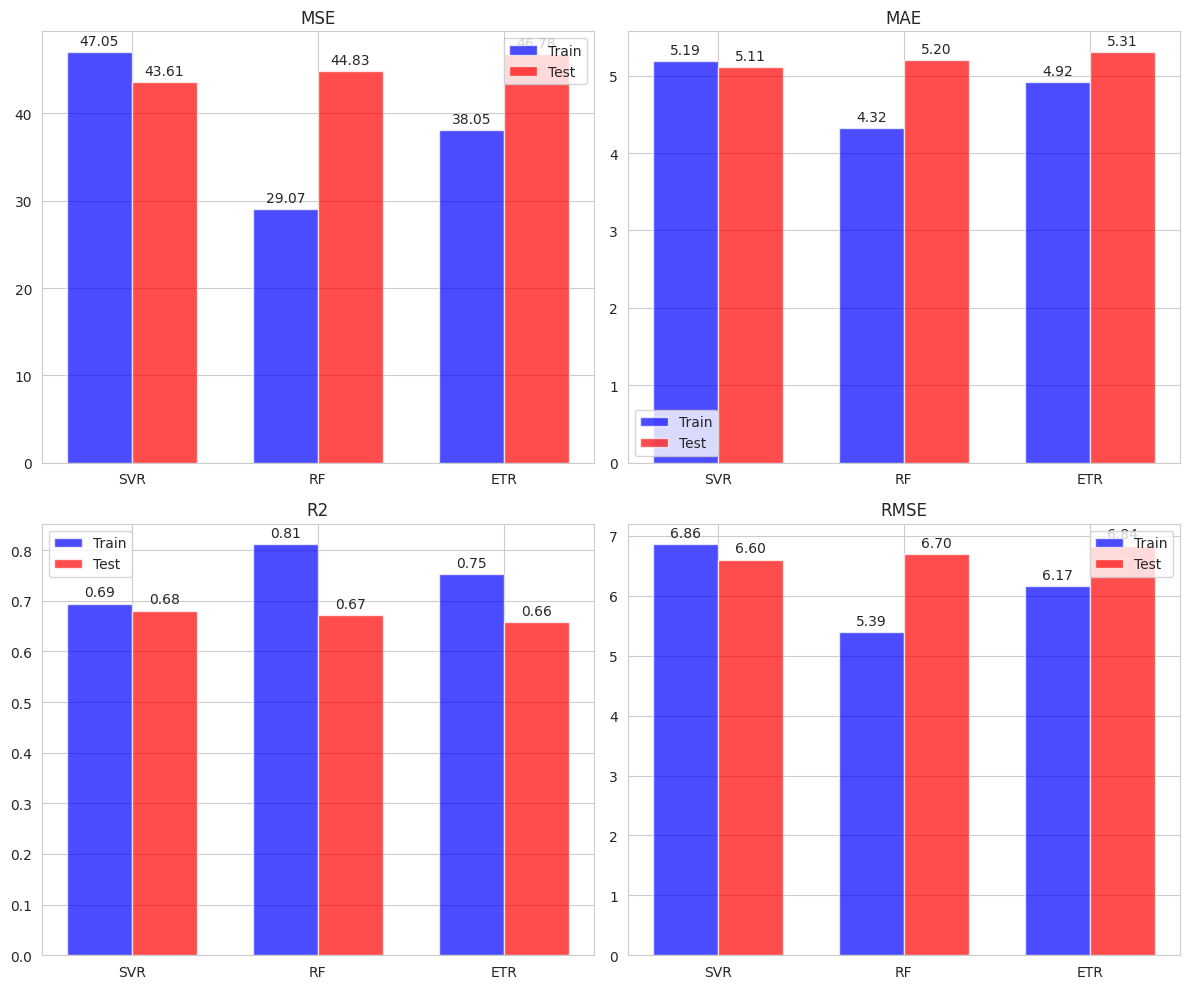

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir nombres de los modelos
model_names = ['SVR', 'RF', 'ETR']

# Configurar estilo
sns.set_style("whitegrid")
metrics = ['MSE', 'MAE', 'R2', 'RMSE']
data_train = [new_mse_train, new_mae_train, new_r2_train, new_rmse_train]
data_test = [new_mse_test, new_mae_test, new_r2_test, new_rmse_test]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    x = np.arange(len(model_names))
    width = 0.35  # Ancho de las barras

    # Graficar barras para train y test
    bars1 = ax.bar(x - width/2, data_train[i], width, label='Train', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, data_test[i], width, label='Test', color='red', alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_title(metrics[i])
    ax.legend()
    ax.bar_label(bars1, fmt='%.2f', padding=3)
    ax.bar_label(bars2, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

<ipython-input-9-74fd6c136ffd>:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plot_learning_curve(modelo, f"Curva de Aprendizaje {nombre}", x_train, y_train.ravel(), cv=5, n_jobs=-1)


Puntaje de validación cruzada: (0.642917985294879, 0.0343638125326045)


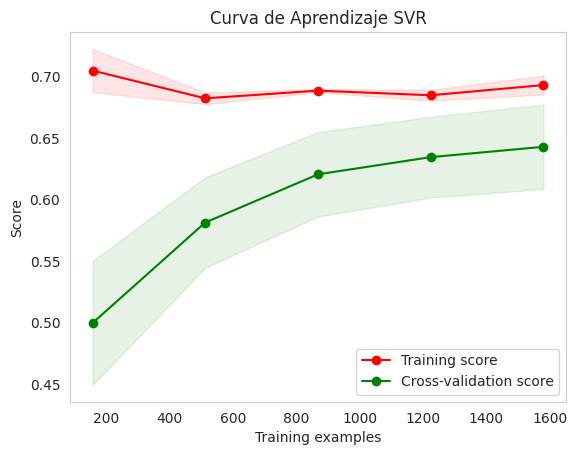

<ipython-input-9-74fd6c136ffd>:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plot_learning_curve(modelo, f"Curva de Aprendizaje {nombre}", x_train, y_train.ravel(), cv=5, n_jobs=-1)


Puntaje de validación cruzada: (0.6206887771387226, 0.03595058409172219)


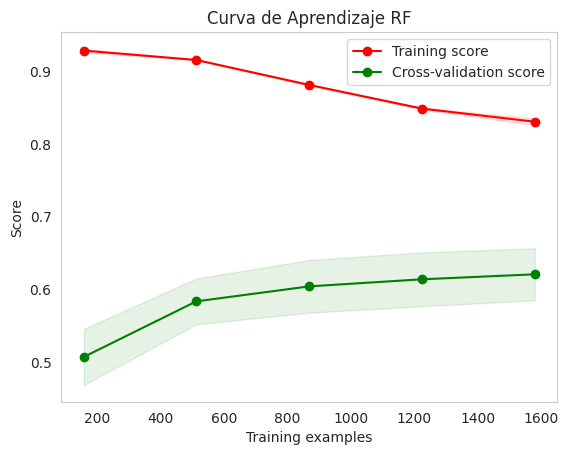

<ipython-input-9-74fd6c136ffd>:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plot_learning_curve(modelo, f"Curva de Aprendizaje {nombre}", x_train, y_train.ravel(), cv=5, n_jobs=-1)


Puntaje de validación cruzada: (0.6172122280178909, 0.031120681205024064)


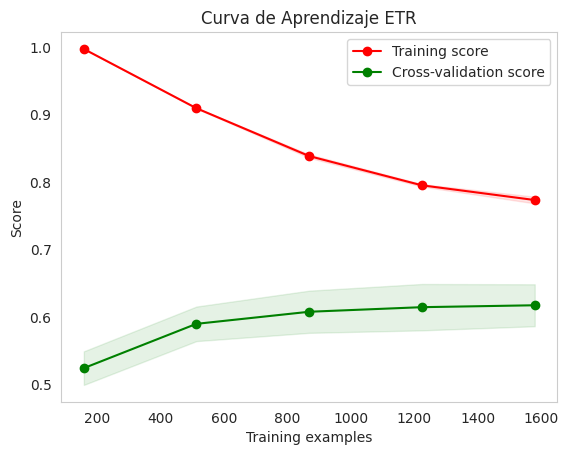

In [ ]:
# Curva de aprendizaje
from sklearn.model_selection import learning_curve, cross_val_score

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=10, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')

    results = cross_val_score(estimator, X, y, scoring='r2')


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    print(f"Puntaje de validación cruzada: {results.mean(), results.std()}")
    return plt

for nombre, modelo in models:
    plot_learning_curve(modelo, f"Curva de Aprendizaje {nombre}", x_train, y_train.ravel(), cv=5, n_jobs=-1)
    plt.show()

In [ ]:
print(f'Total de datos disponibles: {dataI1.shape}')

Total de datos disponibles: (2469, 18)


# *Validación Cruzada SVR*

---



In [ ]:
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from tabulate import tabulate

svr = SVR(C = 100.0, epsilon = 1.0, gamma = 'scale', kernel = 'rbf')
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results_svr = pd.DataFrame(data)

print(tabulate(df_results_svr, headers='keys', tablefmt='grid'))

+----+-----------+--------------+-------------+
|    | Métrica   |   Train Mean |   Train Std |
+====+===========+==============+=============+
|  0 | R2        |      0.63771 |    0.058186 |
+----+-----------+--------------+-------------+
|  1 | MAE       |      5.72491 |    0.415551 |
+----+-----------+--------------+-------------+
|  2 | MSE       |     55.0023  |    8.28705  |
+----+-----------+--------------+-------------+
|  3 | RMSE      |      7.39713 |    0.533544 |
+----+-----------+--------------+-------------+


# *Validación Cruzada ExtraTrees*

---

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

et = ExtraTreesRegressor(n_estimators=300, max_depth=180, max_leaf_nodes=70, criterion='squared_error', random_state=4)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(et, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(et, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(et, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(et, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results_et = pd.DataFrame(data)
print('Resultados iniciales.')
print(tabulate(df_results_et, headers='keys', tablefmt='grid'))

Resultados iniciales.
+----+-----------+--------------+-------------+
|    | Métrica   |   Train Mean |   Train Std |
+====+===========+==============+=============+
|  0 | R2        |     0.609164 |   0.0682423 |
+----+-----------+--------------+-------------+
|  1 | MAE       |     5.96477  |   0.457529  |
+----+-----------+--------------+-------------+
|  2 | MSE       |    59.1144   |   8.01111   |
+----+-----------+--------------+-------------+
|  3 | RMSE      |     7.67122  |   0.516624  |
+----+-----------+--------------+-------------+


# *Validación Cruzada RandomForest*

---

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

rf = RandomForestRegressor(n_estimators=300, max_depth=180, max_leaf_nodes=70, criterion='squared_error', random_state=4)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results_rf = pd.DataFrame(data)

print(tabulate(df_results_rf, headers='keys', tablefmt='grid'))

+----+-----------+--------------+-------------+
|    | Métrica   |   Train Mean |   Train Std |
+====+===========+==============+=============+
|  0 | R2        |     0.614916 |   0.0741605 |
+----+-----------+--------------+-------------+
|  1 | MAE       |     5.89981  |   0.472167  |
+----+-----------+--------------+-------------+
|  2 | MSE       |    58.1303   |   8.37315   |
+----+-----------+--------------+-------------+
|  3 | RMSE      |     7.60455  |   0.5487    |
+----+-----------+--------------+-------------+


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import pandas as pd
import tabulate

# Definición de modelos
svr = SVR(C=100.0, epsilon=1.0, gamma='scale', kernel='rbf')
et = ExtraTreesRegressor(n_estimators=300, max_depth=180, max_leaf_nodes=70, criterion='squared_error', random_state=4)
rf = RandomForestRegressor(n_estimators=300, max_depth=180, max_leaf_nodes=70, criterion='squared_error', random_state=4)

# Listas para almacenar los resultados
modelos = [svr, et, rf]
model_names = ['SVR', 'ExtraTrees', 'RandomForest']
resultados_train = []

# Iteración sobre los modelos
for model in modelos:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # Métricas de rendimiento
    r2_train = cross_val_score(model, x_train, y_train, cv=kfold, scoring='r2')
    mae_train = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    mse_train = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse_train = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

    # Almacenar resultados de entrenamiento
    results_train = {
        "Modelo": model_names[modelos.index(model)],
        "R2 Mean Train": r2_train.mean(),
        "R2 Std Train": r2_train.std(),
        "MAE Mean Train": -mae_train.mean(),
        "MAE Std Train": mae_train.std(),
        "MSE Mean Train": -mse_train.mean(),
        "MSE Std Train": mse_train.std(),
        "RMSE Mean Train": -rmse_train.mean(),
        "RMSE Std Train": rmse_train.std()
    }
    resultados_train.append(results_train)

# Crear dataframe con los resultados de entrenamiento
df_resultados_train = pd.DataFrame(resultados_train)

# Mostrar resultados
df_resultados_train

,Modelo,R2 Mean Train,R2 Std Train,MAE Mean Train,MAE Std Train,MSE Mean Train,MSE Std Train,RMSE Mean Train,RMSE Std Train
0,SVR,0.637710,0.058186,5.724909,0.415551,55.002273,8.287048,7.397135,0.533544
1,ExtraTrees,0.609164,0.068242,5.964769,0.457529,59.114444,8.011113,7.671215,0.516624
2,RandomForest,0.614916,0.074160,5.899806,0.472167,58.130305,8.373147,7.604553,0.548700


In [ ]:
cv_r2_resultados_df = df_resultados_train[['Modelo', 'R2 Mean Train', 'R2 Std Train']].sort_values(by='R2 Mean Train', ascending=False)
cv_mae_resultados_df = df_resultados_train[['Modelo', 'MAE Mean Train', 'MAE Std Train']].sort_values(by='MAE Mean Train', ascending=False)
cv_mse_resultados_df = df_resultados_train[['Modelo', 'MSE Mean Train', 'MSE Std Train']].sort_values(by='MSE Mean Train', ascending=False)
cv_rmse_resultados_df = df_resultados_train[['Modelo', 'RMSE Mean Train', 'RMSE Std Train']].sort_values(by='RMSE Mean Train', ascending=False)

<ipython-input-14-baad2a48ad2a>:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='r2') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='r2') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='r2') for i, model_name in

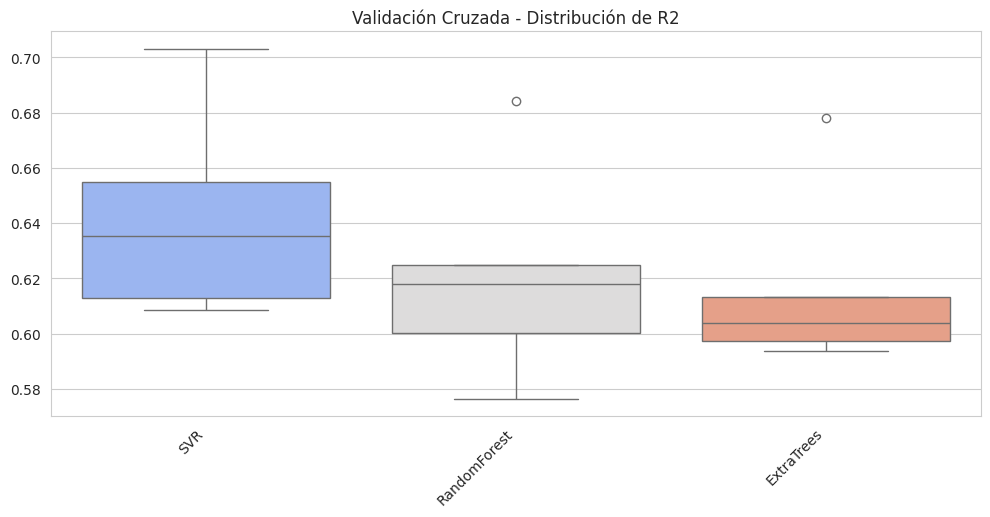

<ipython-input-14-baad2a48ad2a>:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(

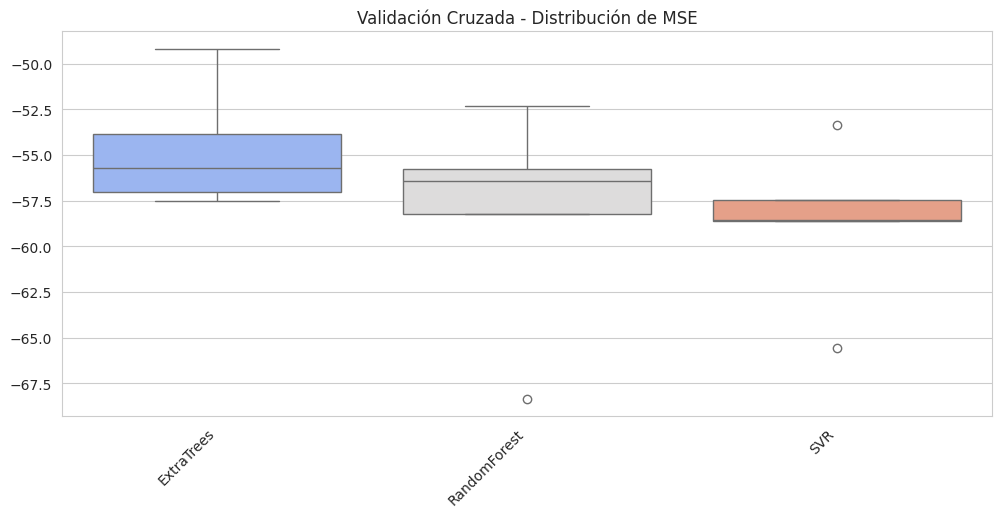

<ipython-input-14-baad2a48ad2a>:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_absolute_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_absolute_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.rave

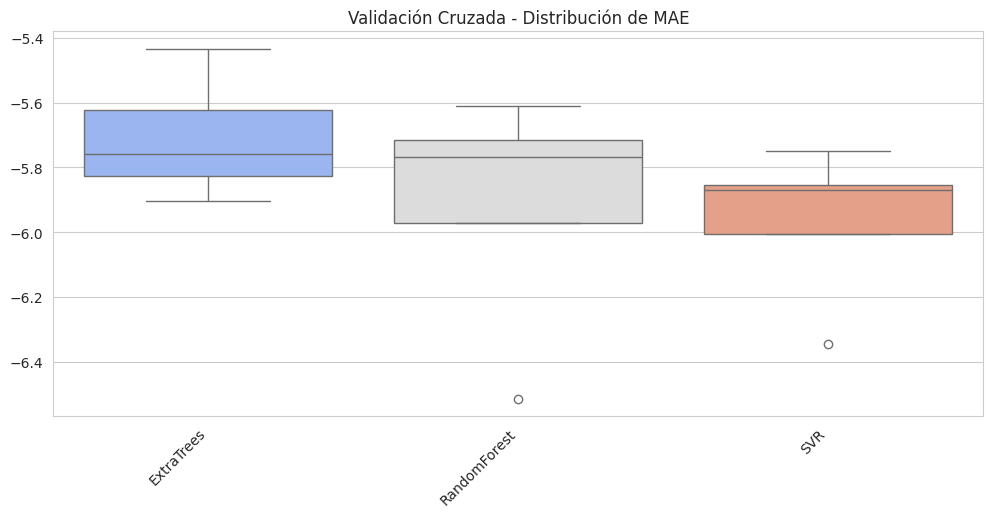

<ipython-input-14-baad2a48ad2a>:44: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_root_mean_squared_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:44: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_root_mean_squared_error') for i, model_name in enumerate(model_names)],
<ipython-input-14-baad2a48ad2a>:44: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_tr

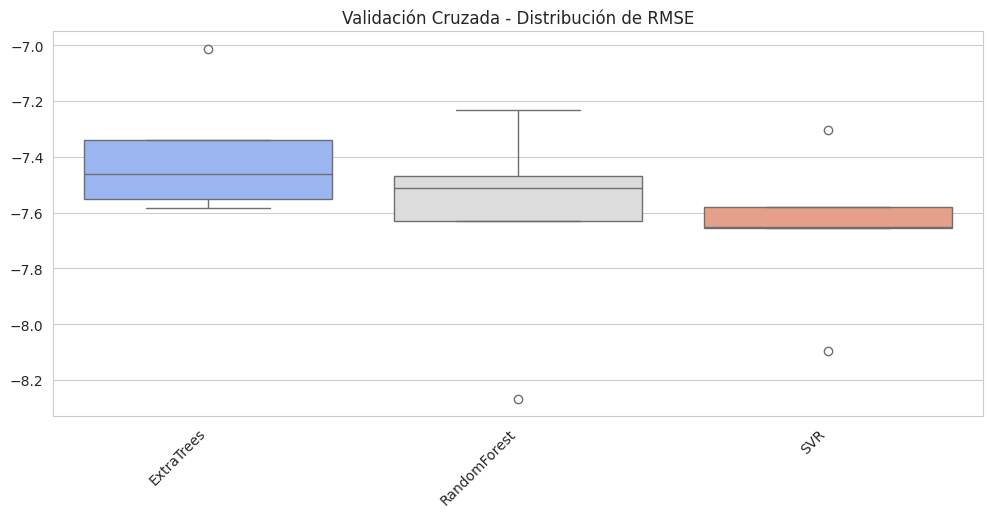

In [ ]:
# Gráfico de validación cruzada de boxplot

plt.figure(figsize=(12, 5))
# Get model names from cv_r2_resultados_df
model_names = cv_r2_resultados_df['Modelo'].tolist()
# Iterate using enumerate to get index and model name
# Access the model object using [1] from the tuple
sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='r2') for i, model_name in enumerate(model_names)],
            palette='coolwarm')
# Use model names for x-axis labels
plt.xticks(range(len(model_names)), model_names, rotation=45, ha="right")
plt.title('Validación Cruzada - Distribución de R2')
plt.show()

plt.figure(figsize=(12, 5))
# Get model names from cv_mse_resultados_df
model_names = cv_mse_resultados_df['Modelo'].tolist()
# Iterate using enumerate to get index and model name
# Access the model object using [1] from the tuple
sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error') for i, model_name in enumerate(model_names)],
            palette='coolwarm')
# Use model names for x-axis labels
plt.xticks(range(len(model_names)), model_names, rotation=45, ha="right")
plt.title('Validación Cruzada - Distribución de MSE')
plt.show()

plt.figure(figsize=(12, 5))
# Get model names from cv_mae_resultados_df
model_names = cv_mae_resultados_df['Modelo'].tolist()
# Iterate using enumerate to get index and model name
# Access the model object using [1] from the tuple
sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_mean_absolute_error') for i, model_name in enumerate(model_names)],
            palette='coolwarm')
# Use model names for x-axis labels
plt.xticks(range(len(model_names)), model_names, rotation=45, ha="right")
plt.title('Validación Cruzada - Distribución de MAE')
plt.show()

plt.figure(figsize=(12, 5))
# Get model names from cv_rmse_resultados_df
model_names = cv_rmse_resultados_df['Modelo'].tolist()
# Iterate using enumerate to get index and model name
# Access the model object using [1] from the tuple
sns.boxplot(data=[cross_val_score(models[i][1], x_train, y_train.ravel(), cv=5, scoring='neg_root_mean_squared_error') for i, model_name in enumerate(model_names)],
            palette='coolwarm')
# Use model names for x-axis labels
plt.xticks(range(len(model_names)), model_names, rotation=45, ha="right")
plt.title('Validación Cruzada - Distribución de RMSE')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import numpy as np

param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1, 2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svr_model = SVR()

grid_svr = GridSearchCV(svr_model, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_svr.fit(x_train, y_train.ravel())
best_svr = grid_svr.best_estimator_

print("\n✅ Mejor combinación de hiperparámetros para SVR:")
print(grid_svr.best_params_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


<ipython-input-13-6e6f6237accc>:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_svr.fit(x_train, y_train.ravel())



✅ Mejor combinación de hiperparámetros para SVR:
{'C': 100, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from tabulate import tabulate

svr = SVR(C = 100.0, epsilon = 2.0, gamma = 'scale', kernel = 'rbf')
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results = pd.DataFrame(data)
print('Resultados después de la optimización de hiperparámetros.')
print(tabulate(df_results, headers='keys', tablefmt='grid'))

Resultados después de la optimización de hiperparámetros.
+----+-----------+--------------+-------------+-------------+------------+
|    | Métrica   |   Train Mean |   Train Std |   Test Mean |   Test Std |
+====+===========+==============+=============+=============+============+
|  0 | R2        |     0.641368 |   0.0569579 |    0.638263 |  0.0607777 |
+----+-----------+--------------+-------------+-------------+------------+
|  1 | MAE       |     5.69876  |   0.418974  |    5.41408  |  0.811063  |
+----+-----------+--------------+-------------+-------------+------------+
|  2 | MSE       |    54.485    |   8.34985   |   48.2615   | 13.0147    |
+----+-----------+--------------+-------------+-------------+------------+
|  3 | RMSE      |     7.36168  |   0.539116  |    6.89471  |  0.851157  |
+----+-----------+--------------+-------------+-------------+------------+


In [ ]:
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from tabulate import tabulate

svr = SVR(C = 100.0, epsilon = 2.0, gamma = 'scale', kernel = 'rbf')
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(svr, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results = pd.DataFrame(data)
print('Resultados después de la optimización de hiperparámetros.')
print(tabulate(df_results, headers='keys', tablefmt='grid'))

Resultados después de la optimización de hiperparámetros.
+----+-----------+--------------+-------------+
|    | Métrica   |   Train Mean |   Train Std |
+====+===========+==============+=============+
|  0 | R2        |     0.641368 |   0.0569579 |
+----+-----------+--------------+-------------+
|  1 | MAE       |     5.69876  |   0.418974  |
+----+-----------+--------------+-------------+
|  2 | MSE       |    54.485    |   8.34985   |
+----+-----------+--------------+-------------+
|  3 | RMSE      |     7.36168  |   0.539116  |
+----+-----------+--------------+-------------+


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [20, 40, 80, 90],
    'min_samples_split': [2, 5, 10, 20],
    'max_leaf_nodes': [20, 40, 60, 80]
}

rf_model = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_rf.fit(x_train, y_train.ravel())

best_rf = grid_rf.best_estimator_
print("\n✅ Mejor combinación de hiperparámetros para Random Forest:")
print(grid_rf.best_params_)

<ipython-input-15-e38667ec1ac8>:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_rf.fit(x_train, y_train.ravel())


Fitting 5 folds for each of 256 candidates, totalling 1280 fits

✅ Mejor combinación de hiperparámetros para Random Forest:
{'max_depth': 20, 'max_leaf_nodes': 80, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

rf = RandomForestRegressor(n_estimators=200, max_depth=20, max_leaf_nodes=80, min_samples_split=5, criterion='squared_error', random_state=4)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_train_r2 = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='r2')
results_train_mae = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
results_train_mse = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
results_train_rmse = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

data = {
    "Métrica": ["R2", "MAE", "MSE", "RMSE"],
    "Train Mean": [results_train_r2.mean(), -results_train_mae.mean(), -results_train_mse.mean(), -results_train_rmse.mean()],
    "Train Std": [results_train_r2.std(), results_train_mae.std(), results_train_mse.std(), results_train_rmse.std()],
}

df_results = pd.DataFrame(data)

print(tabulate(df_results, headers='keys', tablefmt='grid'))

+----+-----------+--------------+-------------+
|    | Métrica   |   Train Mean |   Train Std |
+====+===========+==============+=============+
|  0 | R2        |     0.617159 |   0.0735188 |
+----+-----------+--------------+-------------+
|  1 | MAE       |     5.87512  |   0.474589  |
+----+-----------+--------------+-------------+
|  2 | MSE       |    57.8122   |   8.46457   |
+----+-----------+--------------+-------------+
|  3 | RMSE      |     7.58311  |   0.555488  |
+----+-----------+--------------+-------------+


In [ ]:
from sklearn.svm import SVR

svr = SVR(C = 100.0, epsilon = 2.0, gamma = 'scale', kernel = 'rbf')
svr.fit(x_train, y_train.ravel())

predict = svr.predict(dataI1.drop(columns=['pobreza_m'], axis=1))
predict = np.round(predict, 1)
df_pred_act = pd.DataFrame(predict, columns=['Modelo SVR'])
df_pred_act['Real'] = dataI1['pobreza_m']
df_pred_act['Diferencia'] = df_pred_act['Modelo SVR'] - df_pred_act['Real']

print('Predicciones vs valores reales.')
print(df_pred_act.head(10))
print('Estadísticas.')
print(df_pred_act.describe()['Diferencia'])


<ipython-input-8-53fcb49d31ae>:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  svr.fit(x_train, y_train.ravel())


Predicciones vs valores reales.
   Modelo SVR  Real  Diferencia
0        23.2  21.7         1.5
1        41.5  36.0         5.5
2        42.4  41.3         1.1
3        38.4  33.7         4.7
4        25.5  23.1         2.4
5        35.2  26.0         9.2
6        39.4  34.9         4.5
7        40.8  43.4        -2.6
8        43.7  34.5         9.2
9        37.9  35.8         2.1
Estadísticas.
count    2469.00000
mean       -0.00737
std         6.77909
min       -31.00000
25%        -4.10000
50%        -0.20000
75%         4.00000
max        31.00000
Name: Diferencia, dtype: float64
